# 클러스터링 분석

## K-means, GMM, Spectral, HDBSCAN 클러스터링 적용

## XAI 해석 (SHAP, LIME, Permutation Importance 적용)

### 사용할 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

In [2]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

In [3]:
# macOS에서 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스(-)가 깨질 수 있는 것을 방지함
plt.rcParams['axes.unicode_minus'] = False


### 데이터 불러오기

In [4]:
# 절대경로로 불러옴
df = pd.read_csv("/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/financial_data_processing_cospi200.csv")

# 기업명을 따로 저장한 후, feature만 따로 분리함
company = df['기업명_그룹']
X_raw = df.drop(columns=["기업명_그룹"])

X_raw

,매출액,영업이익,당기순이익,자산총계,자본총계,자본금,영업활동현금흐름,이자발생부채,영업이익률,순이익률,ROE(%),ROA(%),부채비율,EPS(원),PER(배),BPS(원),PBR(배),발행주식수(보통주)
0,78168.10,2353.90,1806.20,30413.75,10074.50,173.00,6499.40,3371.05,3.0045,2.3025,19.1640,6.1845,204.4665,10452.15,13.842000,58318.90,2.5360,17283906.0
1,82983.75,9329.10,7427.55,1402323.10,106667.95,16297.00,1059.20,194600.65,12.1160,9.5230,7.2460,0.5505,1212.4140,2177.75,3.688000,31087.35,0.2545,323323988.3
2,399896.75,21261.65,4553.45,459940.30,173529.85,1790.00,43187.50,182317.25,5.2905,1.1735,3.2850,1.0215,164.8735,4743.30,23.256000,157376.10,0.5830,29176998.0
3,117828.20,4457.35,2185.80,95146.65,40917.65,1141.00,6244.35,33233.10,3.7705,1.8440,5.1870,2.3095,132.5530,8222.50,18.852000,183922.25,0.6120,22812344.0
4,284474.55,14863.60,6214.55,290387.75,115612.75,819.00,20663.90,110318.45,5.2365,2.2195,6.7945,2.2100,151.2490,25676.20,16.468500,433280.45,0.7875,15054186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,168437.95,10420.80,7558.30,476717.70,60701.60,447.00,14037.90,16655.60,6.3260,4.5935,12.1730,1.5880,746.7925,8454.75,3.715000,77333.60,0.3630,89400000.0
195,39464.80,361.90,-312.55,31713.35,7943.10,2000.00,1265.10,16232.85,0.8090,-0.8505,-3.0005,-0.9120,336.9375,-781.90,3.286643,20980.10,3.7785,39248121.0
196,40082.75,2242.65,1152.10,49684.20,13957.55,466.00,2791.35,12929.00,5.2690,2.6040,8.2110,2.2965,269.5100,11180.00,21.237749,135929.25,1.2290,9324548.0
197,77966.55,3994.95,2516.70,42602.50,15773.25,216.00,5586.25,13711.75,5.0295,3.1635,18.9360,6.5965,177.7275,45108.25,33.786000,295216.55,1.1600,4327682.0


### 다중공선성 확인

In [5]:
# X_raw에 상수항 추가 (VIF 계산을 위한 절차)
X_with_const = sm.add_constant(X_raw)

# VIF 계산 (10을 기준으로 함)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(X_with_const.shape[1])]

low_vif_features = vif_data[vif_data['VIF'] <= 10]['Feature']
low_vif_features = low_vif_features[low_vif_features != 'const']  # const 제외

# VIF가 10 이하인 feature만 선택
low_vif_features

4       자산총계
6        자본금
8     이자발생부채
9      영업이익률
10      순이익률
11    ROE(%)
12    ROA(%)
13      부채비율
14    EPS(원)
15    PER(배)
16    BPS(원)
17    PBR(배)
Name: Feature, dtype: object

### 다중공선성 제외 (VIF > 10)

In [6]:
X_raw = X_raw[low_vif_features]

### featurer scaling 수행

In [8]:
# StandardScaler로 정규화한다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
# X_scaled 데이터를 DataFrame으로 변환
X_scaled_df = pd.DataFrame(X_scaled, columns=X_raw.columns)

# CSV 파일로 저장
X_scaled_df.to_csv("X_scaled.csv", index=False, encoding="utf-8-sig")

print("X_scaled 데이터가 'X_scaled.csv'로 저장되었습니다.")

X_scaled 데이터가 'X_scaled.csv'로 저장되었습니다.


### 클러스터링 적용 및 평가 함수 정의

In [9]:
# 클러스터링 성능 평가 함수를 정의함 
# Silhouette Score를 사용함
def evaluate_clustering(model, X, labels=None):
    if (labels is None):
        labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return labels, score

### 최적의 K 찾기

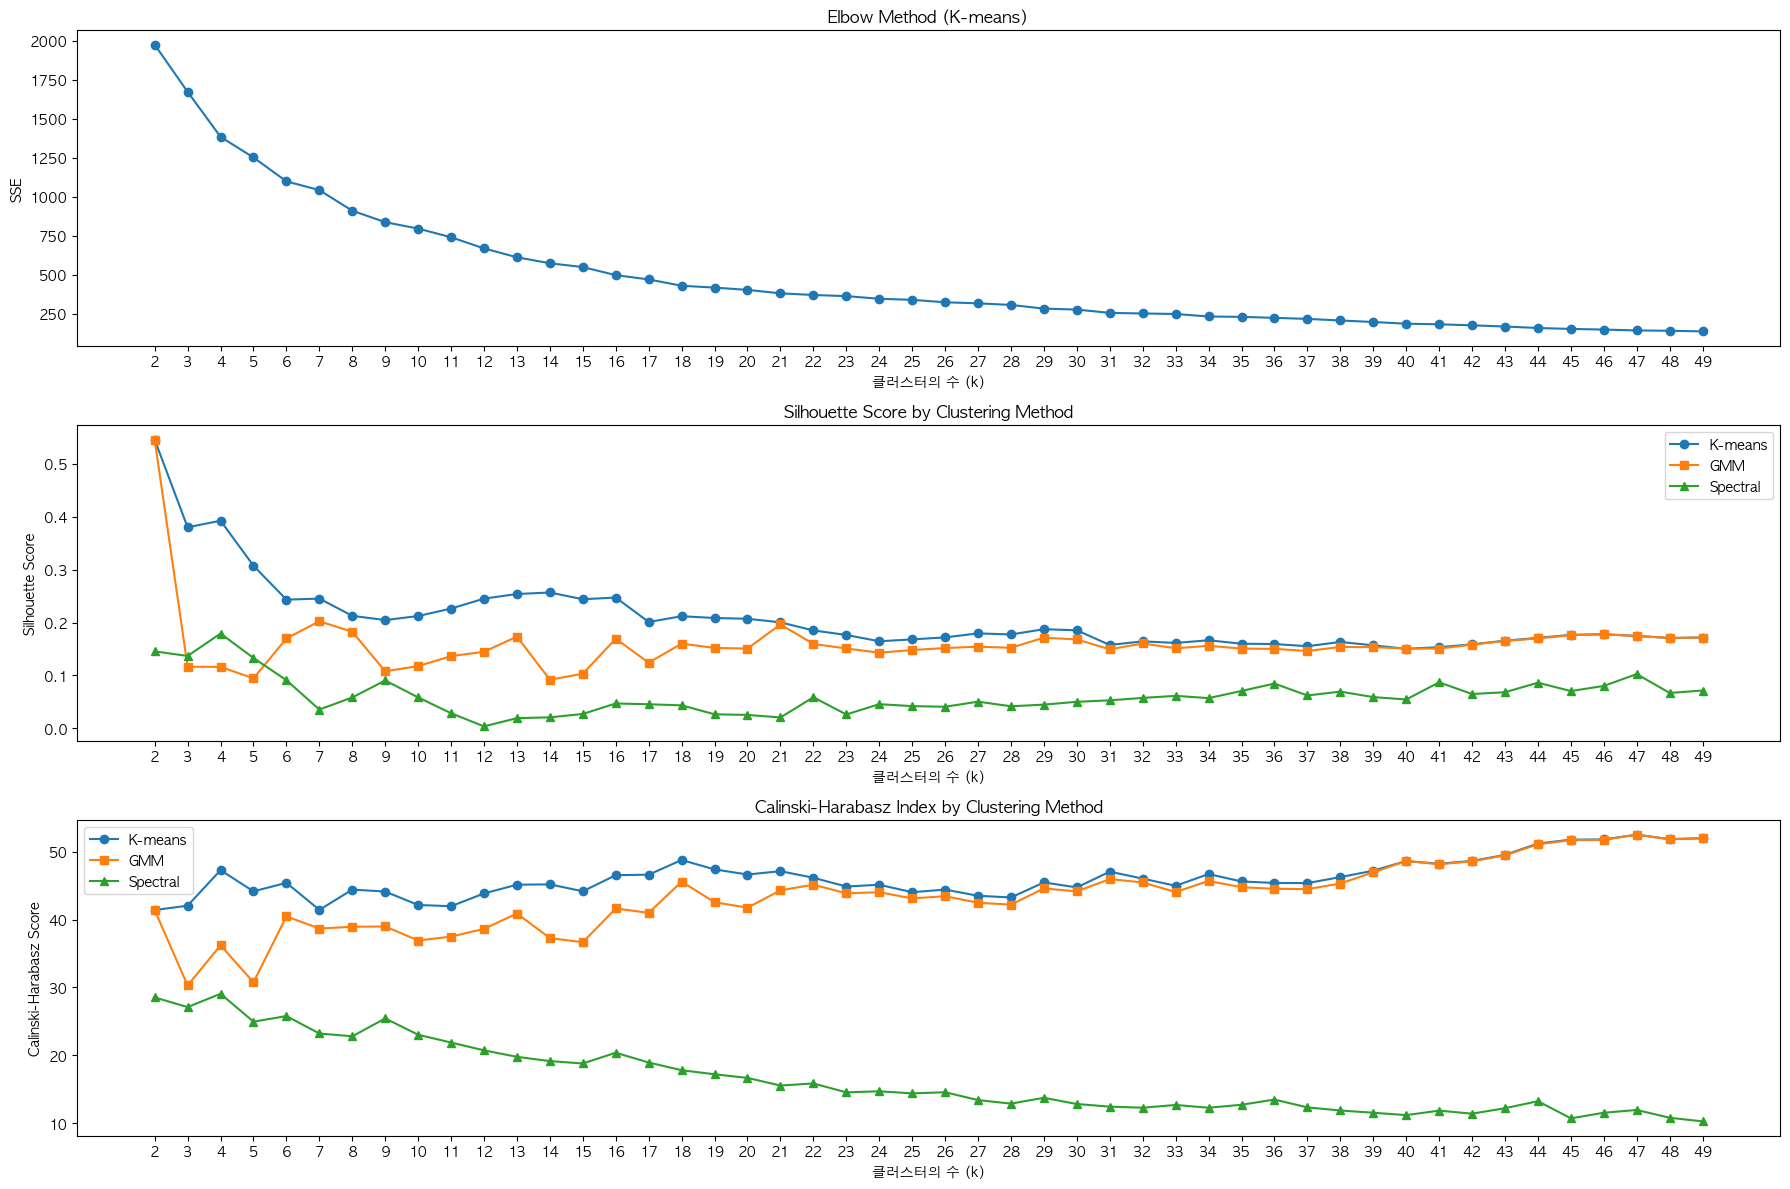

In [10]:
# 후보 K 값 범위 설정
k_values = range(2, 50)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가
for k in k_values:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, kmeans_labels))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    gmm_silhouette_scores.append(silhouette_score(X_scaled, gmm_labels))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled, gmm_labels))
    
    # Spectral clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels = spectral.fit_predict(X_scaled)
    spectral_silhouette_scores.append(silhouette_score(X_scaled, spectral_labels))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled, spectral_labels))

plt.figure(figsize=(18, 12))

# SSE (K-means 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### K-means, GMM, Sperctral Clustering 적용 및 비교

In [11]:
# 3가지 평가 지표를 보고 k값을 결정함

# K-means clustering
# K-means는 k=4에서 가장 높은 점수를 보임
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels, kmeans_score = evaluate_clustering(kmeans, X_scaled)

# GMM
# GMM은 k=7에서 가장 높은 점수를 보임
gmm = GaussianMixture(n_components=7, random_state=42)
gmm_labels, gmm_score = evaluate_clustering(gmm, X_scaled, labels=gmm.fit_predict(X_scaled))

# Spectral clustering
# Spectral clustering은 거의 모든 k의 범위에서 평가가 낮게 나옴
spectral = SpectralClustering(n_clusters=42, random_state=42, affinity='nearest_neighbors')
spectral_labels, spectral_score = evaluate_clustering(spectral, X_scaled)


# Davies-Bouldin Index 계산
# 보통 0.5 ~ 1.0 사이면 괜찮은 클러스터링이라고 함. 실무에서 자주 나오는 수준
kmeans_dbi = davies_bouldin_score(X_scaled, kmeans_labels)
gmm_dbi = davies_bouldin_score(X_scaled, gmm_labels)
spectral_dbi = davies_bouldin_score(X_scaled, spectral_labels)

# 결과 비교 출력
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi:.4f}")
print(f"GMM Davies-Bouldin Index: {gmm_dbi:.4f}")
print(f"Spectral Davies-Bouldin Index: {spectral_dbi:.4f}")

# # 결과 비교
# print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
# print(f"GMM Silhouette Score: {gmm_score:.4f}")
# print(f"Spectral Silhouette Score: {spectral_score:.4f}")


KMeans Davies-Bouldin Index: 0.8965
GMM Davies-Bouldin Index: 1.2007
Spectral Davies-Bouldin Index: 1.6552


### 최종적으로 선택한 클러스터 결과 저장 (K-means)

In [12]:
# K-means가 0.8965로 값이 가장 낮게 나왔다.
df['Cluster'] = kmeans_labels

### Random Forest 학습 - XAI 해석용

In [13]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators은 기본값으로 사용함
clf.fit(X_scaled, kmeans_labels)

RandomForestClassifier(random_state=42)

### SHAP 해석

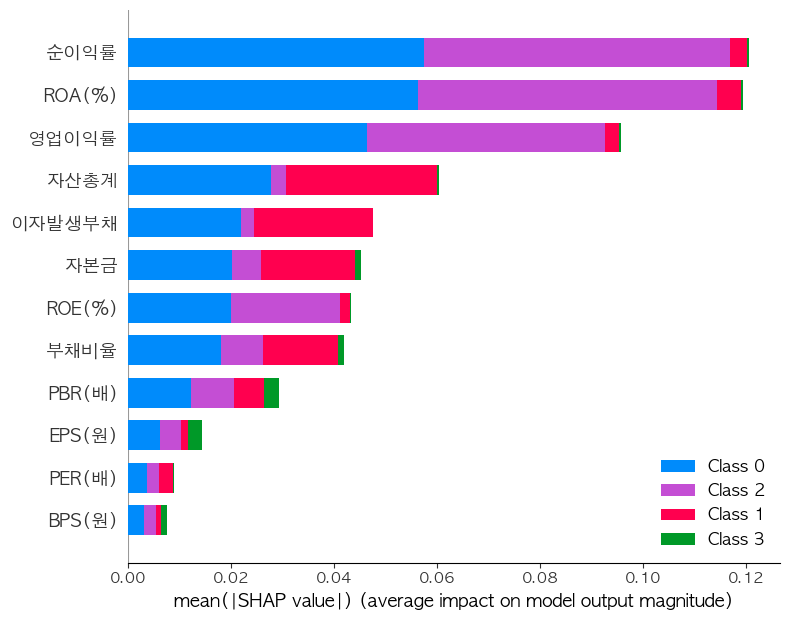

In [14]:
# SHAP 분석
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_scaled)

# feature importance를 시각화함
shap.summary_plot(shap_values, X_raw, plot_type="bar")

In [15]:
# X_raw는 DataFrame, shap_values는 클래스별 리스트 구조라고 가정
feature_names = X_raw.columns
num_classes = len(shap_values)
top_n = 5

for class_idx in range(num_classes):
    print(f"\n🟩 Class {class_idx}에서 가장 중요한 Feature TOP {top_n}:\n" + "-"*50)
    
    # 클래스별 SHAP 절댓값 평균 계산
    class_shap = np.abs(shap_values[class_idx]).mean(axis=0)
    
    # 중요도 순으로 정렬
    top_idx = np.argsort(class_shap)[::-1][:top_n]
    
    for i in top_idx:
        print(f"{feature_names[i]}: 평균 SHAP = {class_shap[i]:.4f}")


🟩 Class 0에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자산총계: 평균 SHAP = 0.0175
이자발생부채: 평균 SHAP = 0.0151
자본금: 평균 SHAP = 0.0042
영업이익률: 평균 SHAP = 0.0004

🟩 Class 1에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자본금: 평균 SHAP = 0.0650
자산총계: 평균 SHAP = 0.0557
이자발생부채: 평균 SHAP = 0.0095
영업이익률: 평균 SHAP = 0.0005

🟩 Class 2에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자산총계: 평균 SHAP = 0.0139
이자발생부채: 평균 SHAP = 0.0094
자본금: 평균 SHAP = 0.0041
영업이익률: 평균 SHAP = 0.0005

🟩 Class 3에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자산총계: 평균 SHAP = 0.0139
이자발생부채: 평균 SHAP = 0.0097
자본금: 평균 SHAP = 0.0042
영업이익률: 평균 SHAP = 0.0005

🟩 Class 4에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자산총계: 평균 SHAP = 0.0140
이자발생부채: 평균 SHAP = 0.0099
자본금: 평균 SHAP = 0.0042
영업이익률: 평균 SHAP = 0.0005

🟩 Class 5에서 가장 중요한 Feature TOP 5:
--------------------------------------------------
자산총계: 평균 SHAP 

### 위에 결과를 보면 각 class 별로 잘 주요한 feature가 나온 것을 확인할 수 있다.

### 각 cluster에 어떤 종목이 포함되어 있는지 확인

In [16]:
# 클러스터별 기업 리스트를 출력한다.
for cluster_id in range(kmeans.n_clusters):
    print(f"[클러스터 {cluster_id}에 속한 종목들]:")
    stock_list = company[kmeans_labels == cluster_id].values
    print(", ".join(stock_list))


[클러스터 0에 속한 종목들]:
BGF리테일, CJ, CJ대한통운, CJ제일제당, DB손해보험, DL, DL이앤씨, GKL, GS, GS건설, GS리테일, HD한국조선해양, HD현대, HD현대미포, HD현대인프라코어, HD현대일렉트릭, HD현대중공업, HL만도, HS효성첨단소재, JB금융지주, KCC, KG모빌리티, KT, LG, LG디스플레이, LG생활건강, LG에너지솔루션, LG유플러스, LG이노텍, LG전자, LG화학, LIG넥스원, LS, LS ELECTRIC, LX인터내셔널, NH투자증권, OCI, OCI홀딩스, PI첨단소재, POSCO홀딩스, S-Oil, SK, SKC, SK네트웍스, SK아이이테크놀로지, SK이노베이션, SK케미칼, SK텔레콤, SK하이닉스, TCC스틸, TKG휴켐스, iM금융지주, 강원랜드, 고려아연, 금호석유화학, 금호타이어, 기아, 넷마블, 녹십자, 녹십자홀딩스, 농심, 대상, 대우건설, 대웅, 대웅제약, 대한유화, 대한전선, 대한항공, 동서, 동원시스템즈, 두산, 두산밥캣, 두산에너빌리티, 두산퓨얼셀, 롯데쇼핑, 롯데웰푸드, 롯데정밀화학, 롯데지주, 롯데칠성, 롯데케미칼, 메리츠금융지주, 미스토홀딩스, 삼성E&A, 삼성SDI, 삼성물산, 삼성생명, 삼성에스디에스, 삼성전기, 삼성전자, 삼성중공업, 삼성증권, 삼성카드, 삼성화재, 삼아알미늄, 세방전지, 세아베스틸지주, 세아제강지주, 신세계, 씨에스윈드, 아모레퍼시픽, 아모레퍼시픽홀딩스, 에스엘, 에스원, 에코프로머티, 엔씨소프트, 엘앤에프, 영원무역, 오뚜기, 오리온홀딩스, 유한양행, 율촌화학, 이마트, 이수스페셜티케미컬, 일진하이솔루스, 제일기획, 종근당, 카카오, 카카오뱅크, 카카오페이, 코스맥스, 코스모신소재, 코스모화학, 코오롱인더, 키움증권, 팬오션, 포스코DX, 포스코인터내셔널, 포스코퓨처엠, 풍산, 하나투어, 하이브, 하이트진로, 한국가스공사, 한국금융지주, 한국앤컴퍼니, 한국콜마, 한국타이어앤테크놀로지, 한국항공우주, 한미사이언스, 한미약품, 한샘, 한세실업, 

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

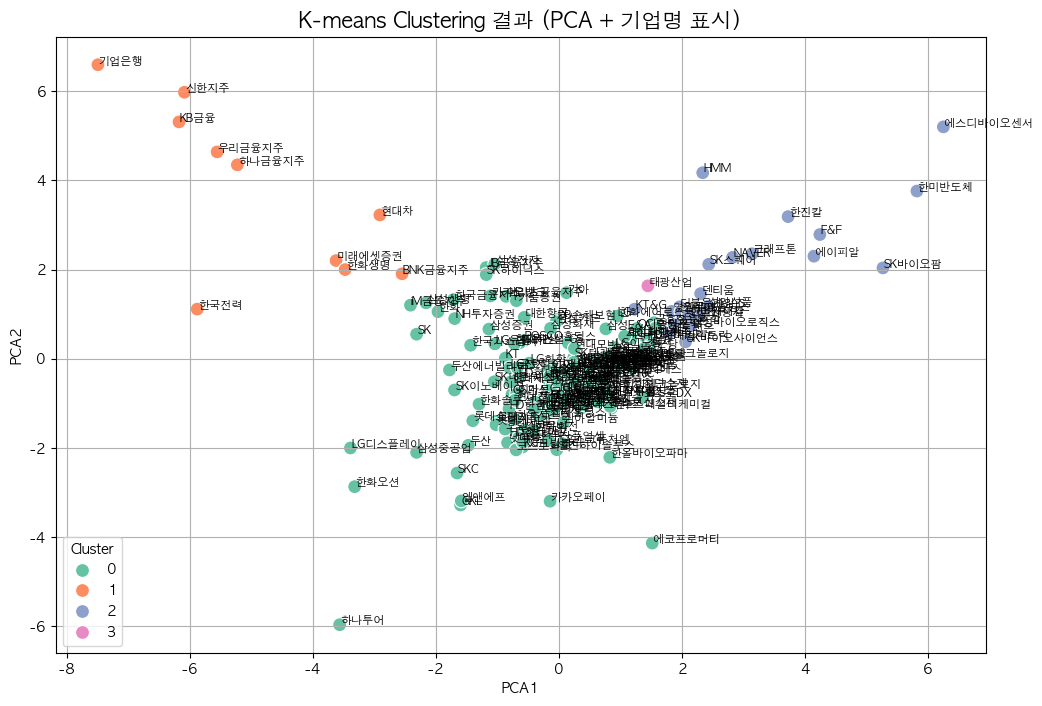

In [17]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company.values,
    'Cluster': kmeans_labels,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("K-means Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()